# Paddy Yield Prediction — Data Analysis & Model Training

This notebook performs:
- **Data Cleaning**: Handle missing values, convert types, handle outliers
- **Exploratory Data Analysis (EDA)**: Visualize distributions, correlations, summaries
- **Data Splitting**: Train (70%), Validation (15%), Test (15%)
- **Feature Scaling**: StandardScaler on inputs
- **Model Selection & Tuning**: RandomizedSearchCV for numeric model, multi-output classification for text
- **Training & Evaluation**: Train models, evaluate on validation and test sets
- **Save Artifacts**: Save models, encoders, scaler to .pkl files

Run cells in order.

In [1]:
# Imports
import os
from pathlib import Path
import pandas as pd
import numpy as np
import joblib
import shutil

# ML libraries
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('✓ All imports successful')

✓ All imports successful


In [4]:
# Set paths
REPO_ROOT = Path('e:\\SmartPaddyAdvisor')  # Explicitly set to project root
DATA_PATH = REPO_ROOT / 'data' / 'SriLanka_Paddy_ML_Dataset.csv'
MODEL_FOLDER = REPO_ROOT / 'backend' / 'model'
EDA_FOLDER = MODEL_FOLDER / 'eda'

MODEL_FOLDER.mkdir(parents=True, exist_ok=True)
EDA_FOLDER.mkdir(parents=True, exist_ok=True)

print(f'Repository root: {REPO_ROOT}')
print(f'Data path: {DATA_PATH}')
print(f'Model folder: {MODEL_FOLDER}')
print(f'EDA folder: {EDA_FOLDER}')

Repository root: e:\SmartPaddyAdvisor
Data path: e:\SmartPaddyAdvisor\data\SriLanka_Paddy_ML_Dataset.csv
Model folder: e:\SmartPaddyAdvisor\backend\model
EDA folder: e:\SmartPaddyAdvisor\backend\model\eda


In [5]:
# Load dataset
print('Loading dataset...')
df = pd.read_csv(DATA_PATH)
print(f'Raw shape: {df.shape}')
print(f'Columns: {list(df.columns)}')
print(f'\nFirst few rows:')
df.head()

Loading dataset...
Raw shape: (100, 30)
Columns: ['FieldID', 'Region', 'FieldArea_ha', 'Soil_pH', 'Temperature_C', 'Humidity_%', 'Rainfall_mm', 'PloughDepth_cm', 'PloughMethod', 'SoilAdjustment_kgLime', 'IrrigationAdvice', 'SeedAmount_kg', 'PlantSpacing_cm', 'Fertilizer_Basal_Urea_kg', 'Fertilizer_Basal_TSP_kg', 'Fertilizer_Basal_MOP_kg', 'WaterManagementAdvice_Stage4', 'TillerIncreaseTip', 'Fertilizer_2ndDose_Urea_kg', 'Fertilizer_2ndDose_TSP_kg', 'Fertilizer_2ndDose_MOP_kg', 'WaterControlAdvice_Stage5', 'WaterControlAdvice_Stage6', 'PesticideSuggestion', 'HumidityTarget_%', 'WaterLevelAdvice_Stage7', 'PredictedYield_kg_ha', 'HarvestingDate', 'FinalMoisture_%', 'PostHarvestAdvice']

First few rows:


,FieldID,Region,FieldArea_ha,Soil_pH,Temperature_C,Humidity_%,Rainfall_mm,PloughDepth_cm,PloughMethod,SoilAdjustment_kgLime,...,Fertilizer_2ndDose_MOP_kg,WaterControlAdvice_Stage5,WaterControlAdvice_Stage6,PesticideSuggestion,HumidityTarget_%,WaterLevelAdvice_Stage7,PredictedYield_kg_ha,HarvestingDate,FinalMoisture_%,PostHarvestAdvice
0,1,Intermediate Low,1.79,3.57,31.1,75.3,2448.8,15,Chisel,537,...,42.96,Flood for 1 week,Reduce water pre-flowering,Chlorpyrifos,86.2,Maintain 3-5cm,4792.3,2026-02-23,14.2,Thresh immediately
1,2,Dry Low,1.02,5.55,31.3,76.4,873.4,17,Mouldboard,571,...,24.48,Flood for 1 week,Ensure moist soil,Fipronil,83.3,Shallow water 3 days,5390.9,2026-02-20,14.3,Sun-dry 3 days
2,3,Intermediate Low,4.26,4.41,31.6,85.2,2314.9,13,Rotavator,785,...,102.24,Maintain 5cm water,Maintain shallow flooding,Chlorpyrifos,84.7,Maintain 3-5cm,4777.1,2026-02-21,14.8,Thresh immediately
3,4,Intermediate Low,3.83,6.08,29.6,76.1,1697.1,14,Rotavator,412,...,91.92,Maintain 5cm water,Reduce water pre-flowering,NaN,87.4,Alternate wetting,4897.4,2026-02-28,14.5,Thresh immediately
4,5,Dry Low,3.92,4.20,29.5,79.8,2488.0,12,Mouldboard,567,...,94.08,Flood for 1 week,Maintain shallow flooding,Fipronil,88.7,Alternate wetting,4475.1,2026-02-24,15.8,Sun-dry 3 days


In [7]:
# Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   FieldID                       100 non-null    int64  
 1   Region                        100 non-null    object 
 2   FieldArea_ha                  100 non-null    float64
 3   Soil_pH                       100 non-null    float64
 4   Temperature_C                 100 non-null    float64
 5   Humidity_%                    100 non-null    float64
 6   Rainfall_mm                   100 non-null    float64
 7   PloughDepth_cm                100 non-null    int64  
 8   PloughMethod                  100 non-null    object 
 9   SoilAdjustment_kgLime         100 non-null    int64  
 10  IrrigationAdvice              100 non-null    object 
 11  SeedAmount_kg                 100 non-null    float64
 12  PlantSpacing_cm               100 non-null    int64  
 13  Fertil

In [8]:
# Define columns
feature_cols = ['Temperature_C', 'Soil_pH', 'Rainfall_mm', 'FieldArea_ha', 'Humidity_%']
numeric_targets = [
    'PredictedYield_kg_ha',
    'PloughDepth_cm',
    'SoilAdjustment_kgLime',
    'SeedAmount_kg',
    'PlantSpacing_cm',
    'Fertilizer_Basal_Urea_kg',
    'Fertilizer_Basal_TSP_kg',
    'Fertilizer_Basal_MOP_kg',
    'Fertilizer_2ndDose_Urea_kg',
    'Fertilizer_2ndDose_TSP_kg',
    'Fertilizer_2ndDose_MOP_kg'
]
text_targets = [
    'PloughMethod',
    'IrrigationAdvice',
    'WaterManagementAdvice_Stage4',
    'TillerIncreaseTip',
    'WaterControlAdvice_Stage5',
    'WaterControlAdvice_Stage6',
    'PesticideSuggestion',
    'PostHarvestAdvice'
]

print(f'Feature columns ({len(feature_cols)}): {feature_cols}')
print(f'Numeric targets ({len(numeric_targets)}): {numeric_targets}')
print(f'Text targets ({len(text_targets)}): {text_targets}')

Feature columns (5): ['Temperature_C', 'Soil_pH', 'Rainfall_mm', 'FieldArea_ha', 'Humidity_%']
Numeric targets (11): ['PredictedYield_kg_ha', 'PloughDepth_cm', 'SoilAdjustment_kgLime', 'SeedAmount_kg', 'PlantSpacing_cm', 'Fertilizer_Basal_Urea_kg', 'Fertilizer_Basal_TSP_kg', 'Fertilizer_Basal_MOP_kg', 'Fertilizer_2ndDose_Urea_kg', 'Fertilizer_2ndDose_TSP_kg', 'Fertilizer_2ndDose_MOP_kg']
Text targets (8): ['PloughMethod', 'IrrigationAdvice', 'WaterManagementAdvice_Stage4', 'TillerIncreaseTip', 'WaterControlAdvice_Stage5', 'WaterControlAdvice_Stage6', 'PesticideSuggestion', 'PostHarvestAdvice']


## Data Cleaning & Preprocessing

In [9]:
# Drop rows missing required columns
needed_cols = feature_cols + numeric_targets + text_targets
df_clean = df.dropna(subset=needed_cols).copy()
print(f'After dropping NA rows: {df_clean.shape} (removed {df.shape[0] - df_clean.shape[0]} rows)')

# Convert numeric columns
for c in feature_cols + numeric_targets:
    df_clean[c] = pd.to_numeric(df_clean[c], errors='coerce')

print('Converted numeric columns')

After dropping NA rows: (73, 30) (removed 27 rows)
Converted numeric columns


In [10]:
# Impute missing feature values with median
print('\nMissing values before imputation:')
print(df_clean[feature_cols].isnull().sum())

df_clean[feature_cols] = df_clean[feature_cols].fillna(df_clean[feature_cols].median())

print('\nMissing values after imputation:')
print(df_clean[feature_cols].isnull().sum())


Missing values before imputation:
Temperature_C    0
Soil_pH          0
Rainfall_mm      0
FieldArea_ha     0
Humidity_%       0
dtype: int64

Missing values after imputation:
Temperature_C    0
Soil_pH          0
Rainfall_mm      0
FieldArea_ha     0
Humidity_%       0
dtype: int64


In [11]:
# Outlier detection and capping (IQR method)
def detect_outliers_iqr(series):
    """Detect outliers using IQR method"""
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    return (series < low) | (series > high)

# Cap outliers
def cap_outliers(series):
    """Cap outliers using IQR method"""
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    return series.clip(lower=low, upper=high)

# Apply capping
for c in feature_cols:
    outlier_count = detect_outliers_iqr(df_clean[c]).sum()
    if outlier_count > 0:
        df_clean[c] = cap_outliers(df_clean[c])
        print(f'{c}: detected and capped {outlier_count} outliers')

In [12]:
# Display cleaned data summary
print('\nCleaned data summary:')
df_clean[feature_cols].describe()


Cleaned data summary:


,Temperature_C,Soil_pH,Rainfall_mm,FieldArea_ha,Humidity_%
count,73.000000,73.000000,73.000000,73.000000,73.000000
mean,29.317808,5.617260,1707.480822,2.878356,82.978082
std,1.365583,1.234639,529.122775,1.159934,4.694419
min,27.100000,3.520000,824.700000,1.020000,75.200000
25%,28.300000,4.450000,1277.600000,1.970000,79.300000
50%,29.500000,5.730000,1711.400000,2.980000,83.600000
75%,30.200000,6.680000,2198.300000,3.920000,87.100000
max,31.900000,7.460000,2499.500000,4.940000,89.900000


## Exploratory Data Analysis (EDA)

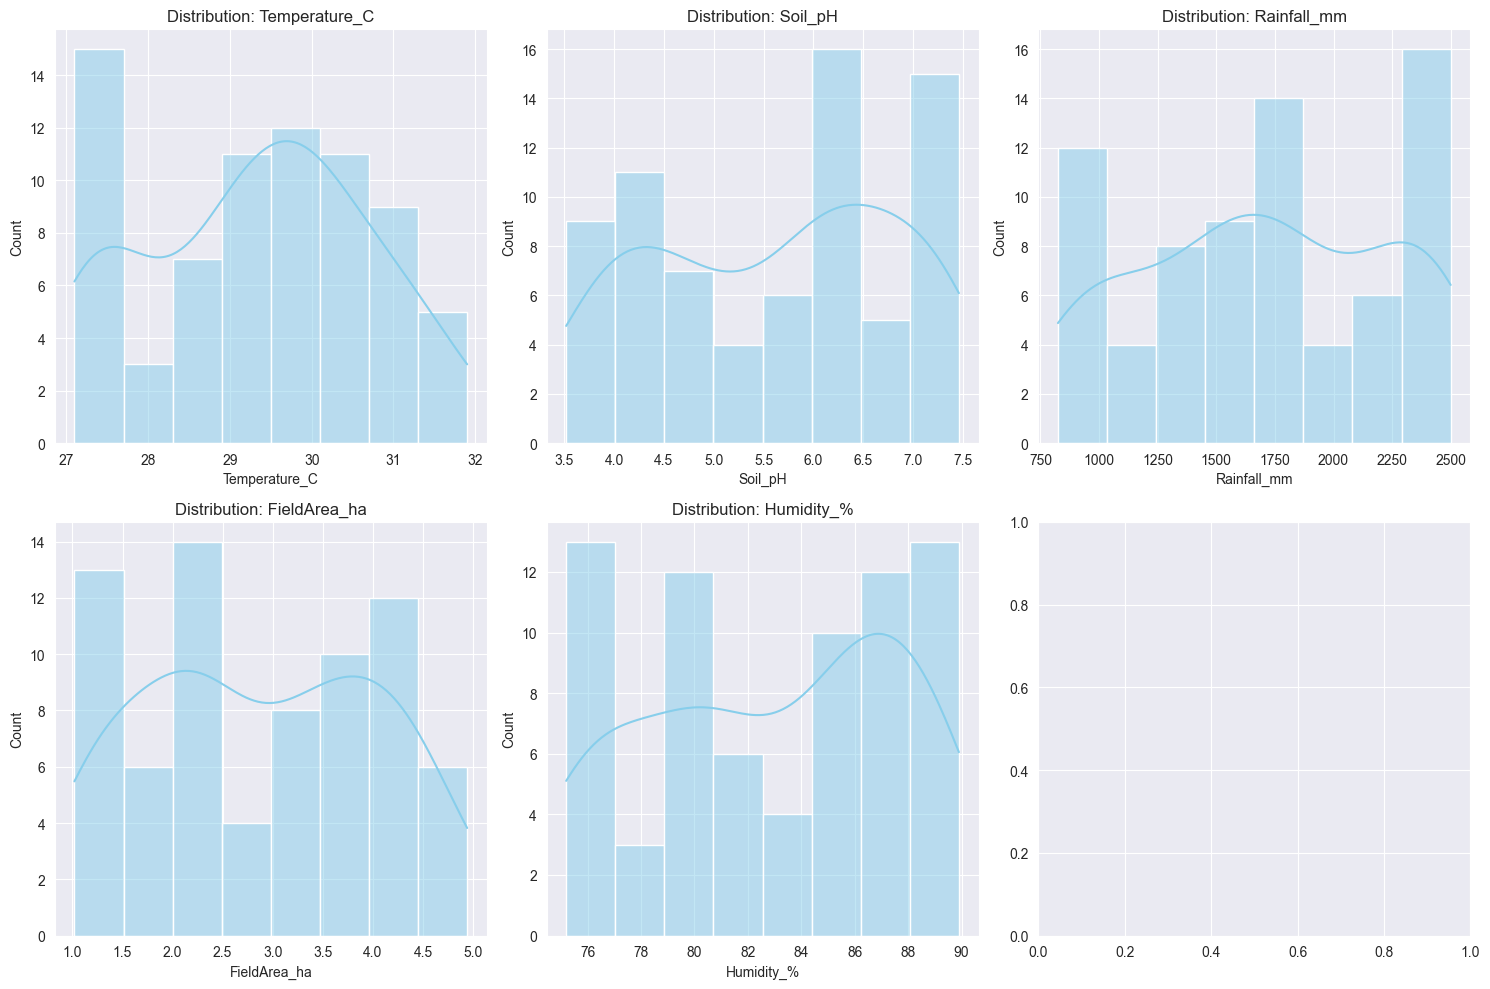

Saved: feature_distributions.png


In [16]:
# Feature distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    sns.histplot(df_clean[col], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution: {col}')

plt.tight_layout()
plt.savefig(EDA_FOLDER / 'feature_distributions.png', dpi=100)
plt.show()
print('Saved: feature_distributions.png')

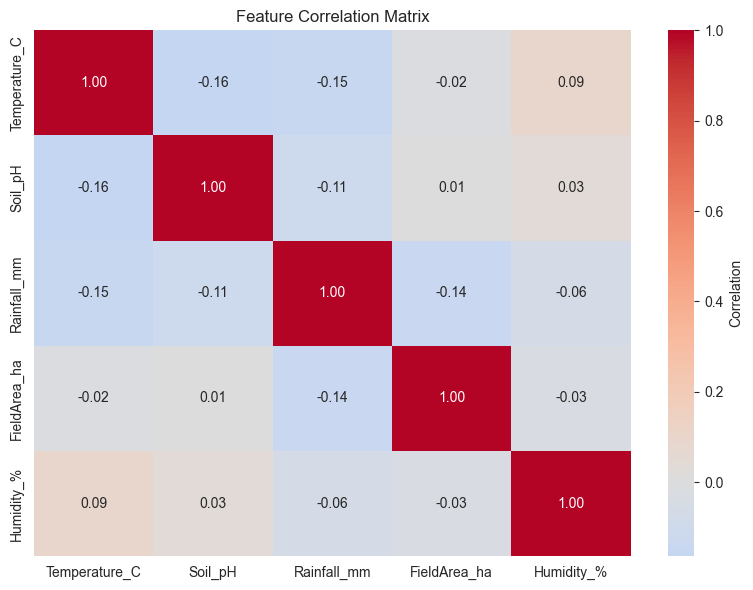

Saved: correlation_matrix.png


In [17]:
# Correlation matrix
corr_matrix = df_clean[feature_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig(EDA_FOLDER / 'correlation_matrix.png', dpi=100)
plt.show()
print('Saved: correlation_matrix.png')

In [18]:
# Save feature summary to CSV
summary = df_clean[feature_cols].describe().T
summary.to_csv(EDA_FOLDER / 'feature_summary.csv')
print('Saved: feature_summary.csv')
summary

Saved: feature_summary.csv


,count,mean,std,min,25%,50%,75%,max
Temperature_C,73.0,29.317808,1.365583,27.10,28.30,29.50,30.20,31.90
Soil_pH,73.0,5.617260,1.234639,3.52,4.45,5.73,6.68,7.46
Rainfall_mm,73.0,1707.480822,529.122775,824.70,1277.60,1711.40,2198.30,2499.50
FieldArea_ha,73.0,2.878356,1.159934,1.02,1.97,2.98,3.92,4.94
Humidity_%,73.0,82.978082,4.694419,75.20,79.30,83.60,87.10,89.90


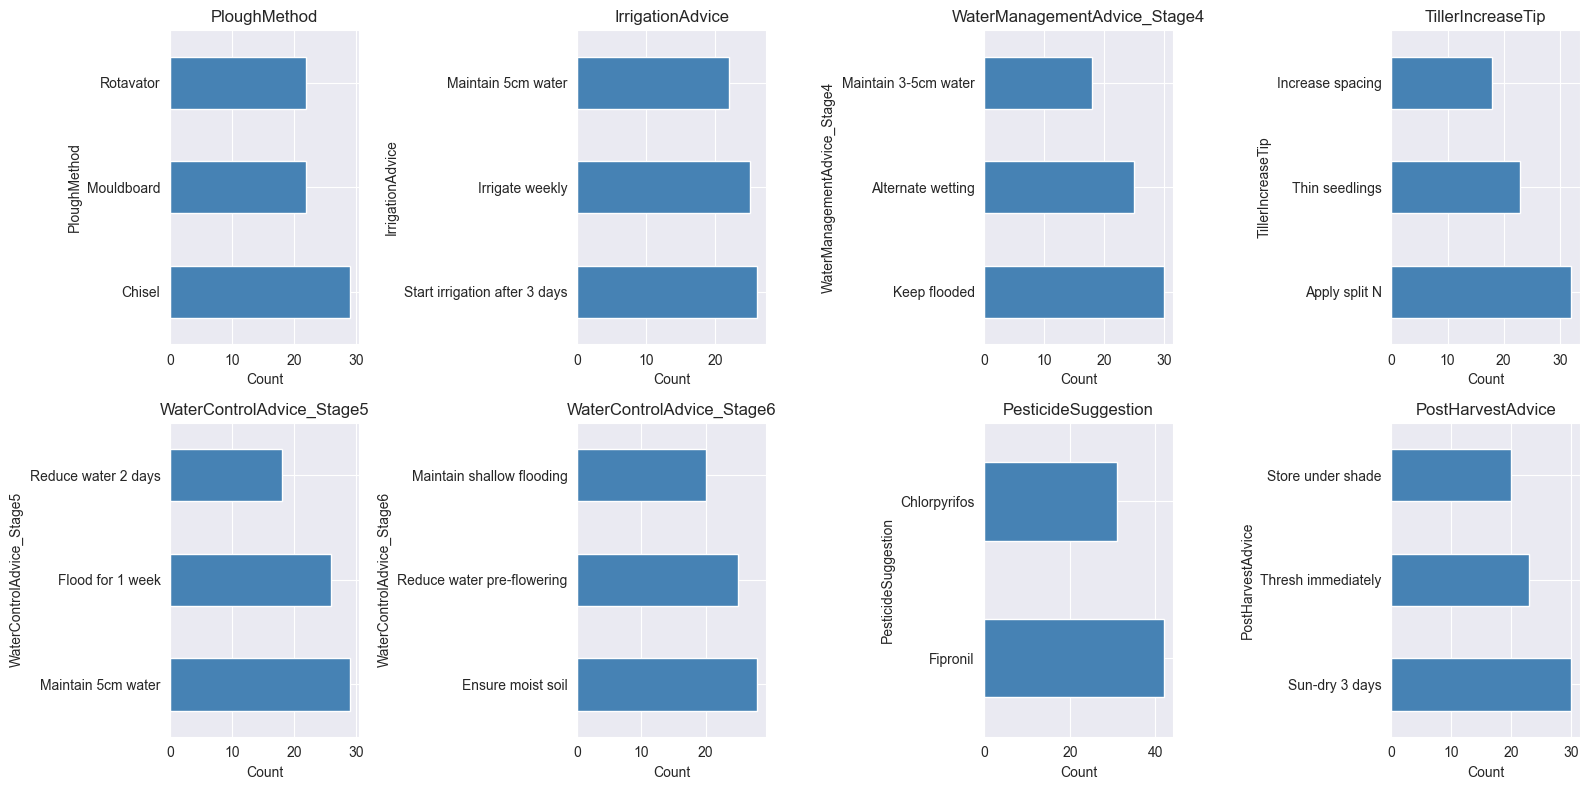

Saved: text_target_distributions.png


In [19]:
# Class distribution for text targets
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(text_targets):
    df_clean[col].value_counts().head(10).plot(kind='barh', ax=axes[i], color='steelblue')
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Count')

plt.tight_layout()
plt.savefig(EDA_FOLDER / 'text_target_distributions.png', dpi=100)
plt.show()
print('Saved: text_target_distributions.png')

## Data Splitting & Feature Scaling

In [20]:
# Prepare X and y
X = df_clean[feature_cols].copy()
y_numeric = df_clean[numeric_targets].copy().astype(float)
y_text = df_clean[text_targets].copy().astype(str)

print(f'X shape: {X.shape}')
print(f'y_numeric shape: {y_numeric.shape}')
print(f'y_text shape: {y_text.shape}')

X shape: (73, 5)
y_numeric shape: (73, 11)
y_text shape: (73, 8)


In [21]:
# Encode text targets
print('Encoding text targets...')
label_encoders = {}
y_text_encoded = pd.DataFrame(index=y_text.index)

for col in text_targets:
    le = LabelEncoder()
    y_text_encoded[col] = le.fit_transform(y_text[col])
    label_encoders[col] = le
    print(f'{col}: {len(le.classes_)} classes')

print('\nEncoding complete!')

Encoding text targets...
PloughMethod: 3 classes
IrrigationAdvice: 3 classes
WaterManagementAdvice_Stage4: 3 classes
TillerIncreaseTip: 3 classes
WaterControlAdvice_Stage5: 3 classes
WaterControlAdvice_Stage6: 3 classes
PesticideSuggestion: 2 classes
PostHarvestAdvice: 3 classes

Encoding complete!


In [22]:
# Train/Validation/Test split (70/15/15)
print('Splitting data: 70% train, 15% val, 15% test...')

X_tmp, X_test, y_num_tmp, y_num_test, y_txt_tmp, y_txt_test = train_test_split(
    X, y_numeric, y_text_encoded, test_size=0.15, random_state=42
)

val_size = 0.176470588  # 0.15 / 0.85
X_train, X_val, y_num_train, y_num_val, y_txt_train, y_txt_val = train_test_split(
    X_tmp, y_num_tmp, y_txt_tmp, test_size=val_size, random_state=42
)

print(f'Train: {X_train.shape}')
print(f'Val: {X_val.shape}')
print(f'Test: {X_test.shape}')

Splitting data: 70% train, 15% val, 15% test...
Train: (51, 5)
Val: (11, 5)
Test: (11, 5)


In [23]:
# Feature scaling
print('Scaling features...')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print('Scaling complete!')

Scaling features...
Scaling complete!


## Model Training
### Numeric Model: RandomForestRegressor with Hyperparameter Tuning

In [24]:
# Hyperparameter tuning with RandomizedSearchCV
print('Tuning numeric model with RandomizedSearchCV...')
print('This may take a few minutes...')

rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['auto', 'sqrt', 0.5],
    'min_samples_split': [2, 5, 10]
}

rnd_search = RandomizedSearchCV(
    rf_base, param_distributions=param_dist, n_iter=8, cv=3,
    scoring='neg_mean_squared_error', n_jobs=-1, random_state=42, verbose=1
)

rnd_search.fit(X_train_scaled, y_num_train)

print(f'\nBest parameters: {rnd_search.best_params_}')
print(f'Best CV score (neg MSE): {rnd_search.best_score_:.4f}')

Tuning numeric model with RandomizedSearchCV...
This may take a few minutes...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


e:\SmartPaddyAdvisor\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
12 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "e:\SmartPaddyAdvisor\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\SmartPaddyAdvisor\.venv\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "e:\SmartPaddyAdvisor\.venv\Lib\site-packages\sklearn\base.py", line 471, in _validate_para


Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 20}
Best CV score (neg MSE): -30679.3353


In [25]:
# Evaluate numeric model
print('Evaluating numeric model...')
best_rf = rnd_search.best_estimator_

y_train_pred = best_rf.predict(X_train_scaled)
y_val_pred = best_rf.predict(X_val_scaled)
y_test_pred = best_rf.predict(X_test_scaled)

train_mse = mean_squared_error(y_num_train, y_train_pred)
val_mse = mean_squared_error(y_num_val, y_val_pred)
test_mse = mean_squared_error(y_num_test, y_test_pred)

print(f'Train MSE: {train_mse:.4f}')
print(f'Validation MSE: {val_mse:.4f}')
print(f'Test MSE: {test_mse:.4f}')

Evaluating numeric model...
Train MSE: 8191.0848
Validation MSE: 21521.4489
Test MSE: 19014.2003


### Text Model: MultiOutputClassifier(RandomForestClassifier)

In [26]:
# Train text model
print('Training text model (MultiOutputClassifier)...')
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
multi_clf = MultiOutputClassifier(rf_clf)
multi_clf.fit(X_train_scaled, y_txt_train)
print('Training complete!')

Training text model (MultiOutputClassifier)...
Training complete!


In [27]:
# Evaluate text model on validation set
print('Evaluating text model on validation set...')
y_val_txt_pred = multi_clf.predict(X_val_scaled)

val_accs = []
for i, col in enumerate(text_targets):
    acc = accuracy_score(y_txt_val[col], y_val_txt_pred[:, i])
    val_accs.append(acc)
    print(f'{col}: {acc:.3f}')

print(f'\nAverage validation accuracy: {np.mean(val_accs):.3f}')

Evaluating text model on validation set...
PloughMethod: 0.364
IrrigationAdvice: 0.364
WaterManagementAdvice_Stage4: 0.455
TillerIncreaseTip: 0.273
WaterControlAdvice_Stage5: 0.545
WaterControlAdvice_Stage6: 0.364
PesticideSuggestion: 0.636
PostHarvestAdvice: 0.273

Average validation accuracy: 0.409


In [28]:
# Evaluate text model on test set
print('Evaluating text model on test set...')
y_test_txt_pred = multi_clf.predict(X_test_scaled)

test_accs = []
for i, col in enumerate(text_targets):
    acc = accuracy_score(y_txt_test[col], y_test_txt_pred[:, i])
    test_accs.append(acc)
    print(f'{col}: {acc:.3f}')

print(f'\nAverage test accuracy: {np.mean(test_accs):.3f}')

Evaluating text model on test set...
PloughMethod: 0.273
IrrigationAdvice: 0.364
WaterManagementAdvice_Stage4: 0.182
TillerIncreaseTip: 0.455
WaterControlAdvice_Stage5: 0.455
WaterControlAdvice_Stage6: 0.182
PesticideSuggestion: 0.000
PostHarvestAdvice: 0.364

Average test accuracy: 0.284


## Save Artifacts

In [29]:
# Save trained models and preprocessing objects
print('Saving artifacts...')

numeric_path = MODEL_FOLDER / 'paddy_model_numeric.pkl'
text_path = MODEL_FOLDER / 'paddy_model_text.pkl'
encoders_path = MODEL_FOLDER / 'label_encoders.pkl'
scaler_path = MODEL_FOLDER / 'scaler.pkl'

joblib.dump(best_rf, numeric_path)
joblib.dump(multi_clf, text_path)
joblib.dump(label_encoders, encoders_path)
joblib.dump(scaler, scaler_path)

print(f'Saved: {numeric_path}')
print(f'Saved: {text_path}')
print(f'Saved: {encoders_path}')
print(f'Saved: {scaler_path}')

Saving artifacts...
Saved: e:\SmartPaddyAdvisor\backend\model\paddy_model_numeric.pkl
Saved: e:\SmartPaddyAdvisor\backend\model\paddy_model_text.pkl
Saved: e:\SmartPaddyAdvisor\backend\model\label_encoders.pkl
Saved: e:\SmartPaddyAdvisor\backend\model\scaler.pkl


In [30]:
# List all files in model folder
print('\nFiles in model folder:')
for f in MODEL_FOLDER.iterdir():
    if f.is_file():
        size_mb = f.stat().st_size / (1024 * 1024)
        print(f'  - {f.name} ({size_mb:.2f} MB)')
    else:
        print(f'  - {f.name}/ (folder)')


Files in model folder:
  - backend/ (folder)
  - eda/ (folder)
  - label_encoders.pkl (0.00 MB)
  - model_train.ipynb (0.02 MB)
  - paddy_model_numeric.pkl (0.81 MB)
  - paddy_model_text.pkl (4.65 MB)
  - scaler.pkl (0.00 MB)
  - train_models.ipynb (0.00 MB)
  - train_models.py (0.01 MB)


## Summary

In [31]:
print('\n' + '='*60)
print('TRAINING COMPLETE')
print('='*60)
print(f'\nDataset: {df_clean.shape[0]} rows used (dropped {df.shape[0] - df_clean.shape[0]} rows)')
print(f'Train/Val/Test: {X_train.shape[0]} / {X_val.shape[0]} / {X_test.shape[0]}')
print(f'\nNumeric Model Performance:')
print(f'  Train MSE: {train_mse:.4f}')
print(f'  Val MSE: {val_mse:.4f}')
print(f'  Test MSE: {test_mse:.4f}')
print(f'\nText Model Performance:')
print(f'  Average Val Accuracy: {np.mean(val_accs):.3f}')
print(f'  Average Test Accuracy: {np.mean(test_accs):.3f}')
print(f'\nArtifacts saved to: {MODEL_FOLDER}')
print(f'EDA plots saved to: {EDA_FOLDER}')
print('='*60)


TRAINING COMPLETE

Dataset: 73 rows used (dropped 27 rows)
Train/Val/Test: 51 / 11 / 11

Numeric Model Performance:
  Train MSE: 8191.0848
  Val MSE: 21521.4489
  Test MSE: 19014.2003

Text Model Performance:
  Average Val Accuracy: 0.409
  Average Test Accuracy: 0.284

Artifacts saved to: e:\SmartPaddyAdvisor\backend\model
EDA plots saved to: e:\SmartPaddyAdvisor\backend\model\eda


## Notes

- **Model artifacts** are saved to `.pkl` files and are **git-ignored** (as intended).
- **EDA plots** and summaries are saved to `backend/model/eda/` for reference.
- To **reproduce training**, run this notebook from the repository root:
  ```bash
  jupyter notebook backend/model/train_models.ipynb
  ```
- For better model performance: collect more data, engineer features, or do per-target tuning.
- **Next steps**: Use the saved artifacts in the backend API for predictions.